In [1]:
import os
# be sure to set your working directory
os.chdir("/Users/lewa8222/Documents/earth-analytics")



{% include toc title="In This Lesson" icon="file-text" %}



<div class='notice--success' markdown="1">



## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives



After completing this tutorial, you will be able to:



* Use the `extract()` function to extract raster values using a vector extent or set of extents.

* Create a scatter plot with a one to one line in `R`.

* Understand the concept of uncertainty as it's associated with remote sensing data.



## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What you need



You will need a computer with internet access to complete this lesson and the data for week 5 of the course.



[<i class="fa fa-download" aria-hidden="true"></i> Download Week 5 Data (~500 MB)](https://ndownloader.figshare.com/files/7525363){:data-proofer-ignore='' .btn }





</div>






In [1]:
# import all libraries




## Import Canopy Height Model



First, we will import a canopy height model created by the NEON project. In the

previous lessons / weeks we learned how to make a canopy height model by

subtracting the Digital elevation model (DEM) from the Digital surface model (DSM).




In [2]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
plt.ion()

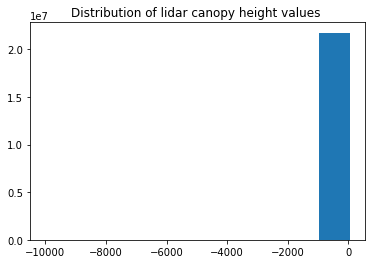

In [13]:
# open canopy height model raster using rasterio.open
SJER_chm = rio.open('data/week5/california/SJER/2013/lidar/SJER_lidarCHM.tif')
bounds = SJER_chm.bounds
# read in data -- not sure if masked = True works
# can we create summary stats on the array?

SJER_chm_data = SJER_chm.read(masked=True)

# plot histogram
# Need to add x and y labels to plot and title 
# note i don't think the -9999 no data value is being masked here properly -- there are no positive values in the histogram?
# how does python handle bins??
fig, ax = plt.subplots()
ax.hist(SJER_chm_data.ravel())
plt.title('Distribution of lidar canopy height values ')







There are a lot of values in our CHM that == 0. Let's set those to `NA` and plot

again.




(array([  1.88095100e+06,   2.31442800e+06,   5.17942000e+05,
          2.73809000e+05,   1.13669000e+05,   1.97720000e+04,
          1.07300000e+03,   3.30000000e+01,   0.00000000e+00,
          9.00000000e+00]),
 array([  2.        ,   6.38799973,  10.77599945,  15.16399918,
         19.5519989 ,  23.93999863,  28.32799835,  32.71599808,
         37.1039978 ,  41.49199753,  45.87999725]),
 <a list of 10 Patch objects>)

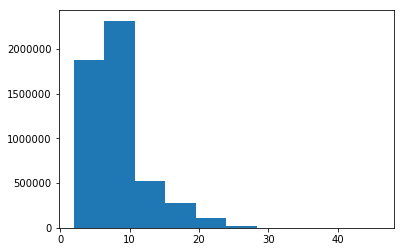

In [14]:
# what is .ravel
SJER_chm_data_ravel = SJER_chm_data.ravel()
SJER_chm_data_ravel = SJER_chm_data_ravel[SJER_chm_data_ravel > 0]

# create histogram 
fig, ax = plt.subplots()
ax.hist(SJER_chm_data_ravel)


In [23]:
# ok so this is a masked array -- need to better understand ravel
# then need to understand how you'd export this to a geotiff if need be. 
type(SJER_chm_data_ravel)

numpy.ma.core.MaskedArray



## Part 2. Does our CHM data compare to field measured tree heights?



We now have a canopy height model for our study area in California. However, how

do the height values extracted from the CHM compare to our laboriously collected,

field measured canopy height data? To figure this out, we will use *in situ* collected

tree height data, measured within circular plots across our study area. We will compare

the maximum measured tree height value to the maximum LiDAR derived height value

for each circular plot using regression.



For this activity, we will use the a `csv` (comma separate value) file,

located in `SJER/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv`.




In [24]:
import geopandas as gpd
from rasterio import plot as riop

In [25]:
SJER_plots = gpd.read_file('data/week5/california/SJER/vector_data/SJER_plot_centroids.shp')

In [26]:
# not sure why this is empty! 
SJER_plots.total_bounds


(254738.61799999999, 4107527.074, 258497.10200000001, 4112167.7779999999)

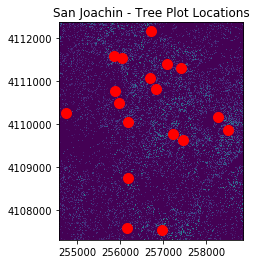

In [30]:
# need to change the cmap to greys
fig, ax = plt.subplots()
ax.imshow(SJER_chm.read()[0], 
          extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
          vmin=data_ravel.min(), 
          vmax=data_ravel.max())
SJER_plots.plot(ax=ax, markersize=10, color='r')
ax.set(title="San Joachin - Tree Plot Locations")

In [1]:
```{r read-plot-data, fig.cap="canopy height model / plot locations plot" }

# import plot centroids

SJER_plots <- readOGR("data/week5/california/SJER/vector_data",

                      "SJER_plot_centroids")



# Overlay the centroid points and the stem locations on the CHM plot

plot(SJER_chm,

     main="SJER  Plot Locations",

     col=gray.colors(100, start=.3, end=.9))



# pch 0 = square

plot(SJER_plots,

     pch = 16,

     cex = 2,

     col = 2,

     add=TRUE)



```




### Extract CMH data within 20 m radius of each plot centroid.



Next, we will create a boundary region (called a buffer) representing the spatial

extent of each plot (where trees were measured). We will then extract all CHM pixels

that fall within the plot boundary to use to estimate tree height for that plot.



There are a few ways to go about this task. If our plots are circular, then we can

use the `extract()` function.



<figure>

    <img src="{{ site.url }}/images/course-materials/earth-analytics/week-5/buffer-circular.png" alt="buffer circular">

    <figcaption>The extract function in R allows you to specify a circular buffer

    radius around an x,y point location. Values for all pixels in the specified

    raster that fall within the circular buffer are extracted. In this case, we

    will tell R to extract the maximum value of all pixels using the fun=max

    command. Source: Colin Williams, NEON

    </figcaption>

</figure>



### Extract Plot Data Using Circle: 20m Radius Plots




In [1]:
```{r extract-plot-data }

# Insitu sampling took place within 40m x 40m square plots, so we use a 20m radius.

# Note that below will return a data.frame containing the max height

# calculated from all pixels in the buffer for each plot

SJER_height <- extract(SJER_chm,

                    SJER_plots,

                    buffer = 20, # specify a 20 m radius

                    fun=mean, # extract the MEAN value from each plot

                    sp=TRUE, # create spatial object

                    stringsAsFactors=FALSE)



```




#### Explore The Data Distribution



If you want to explore the data distribution of pixel height values in each plot,

you could remove the `fun` call to max and generate a list.

`cent_ovrList <- extract(chm,centroid_sp,buffer = 20)`. It's good to look at the

distribution of values we've extracted for each plot. Then you could generate a

histogram for each plot `hist(cent_ovrList[[2]])`. If we wanted, we could loop

through several plots and create histograms using a `for loop`.




In [1]:
```{r explore-data-distribution, eval=FALSE }

# cent_ovrList <- extract(chm,centroid_sp,buffer = 20)

# create histograms for the first 5 plots of data

# for (i in 1:5) {

#  hist(cent_ovrList[[i]], main=(paste("plot",i)))

#  }



```






### Derive Square Plot boundaries, then CHM values around a point

For how to extract square plots using a plot centroid value, check out the

<a href="http://neondataskills.org/working-with-field-data/Field-Data-Polygons-From-Centroids" target="_blank"> extracting square shapes activity </a>.



 <figure>

    <img src="{{ site.url }}/images/course-materials/earth-analytics/week-5/buffer-square.png" alt="Image showing the buffer area for a plot.">

    <figcaption>If you had square shaped plots, the code in the link above would

    extract pixel values within a square shaped buffer. Source: Colin Williams, NEON

    </figcaption>

</figure>







## Extract descriptive stats from *In situ* Data

In our final step, we will extract summary height values from our field data.

We will use the `dplyr` library to do this efficiently.



First let's see how many plots are in our tree height data. Note that our tree

height data is stored in csv format.




In [1]:
```{r unique-plots }

# import the centroid data and the vegetation structure data

SJER_insitu <- read.csv("data/week5/california/SJER/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv",

                        stringsAsFactors = FALSE)



# get list of unique plots

unique(SJER_plots$Plot_ID)



```




## Extract Max Tree Height



Next, we can use dplyr to extract a summary tree height value for each plot. In

this case, we will calculate the mean MEASURED tree height value for each

plot. This value represents the average tree in each plot. We will also calculate

the max height representing the max height for each plot.



FInally, we will compare the mean measured tree height per plot to the mean

tree height extracted from the lidar CHM.




In [1]:
```{r analyze-plot-dplyr }

# find the max and mean stem height for each plot

insitu_stem_height <- SJER_insitu %>%

  group_by(plotid) %>%

  summarise(insitu_max = max(stemheight), insitu_avg = mean(stemheight))



# view the data frame to make sure we're happy with the column names.

head(insitu_stem_height)



```






### Merge InSitu Data With Spatial data.frame



Once we have our summarized insitu data, we can `merge` it into the centroids

`data.frame`. Merge requires two data.frames and the names of the columns

containing the unique ID that we will merge the data on. In this case, we will

merge the data on the plot_id column. Notice that it's spelled slightly differently

in both data.frames so we'll need to tell R what it's called in each data.frame.




In [1]:
```{r merge-dataframe}

# merge the insitu data into the centroids data.frame

SJER_height <- merge(SJER_height,

                     insitu_stem_height,

                   by.x = 'Plot_ID',

                   by.y = 'plotid')



SJER_height@data



```




## Plot by height




In [1]:
```{r create-spatial-plot, fig.cap="Plots sized by vegetation height"}

# plot canopy height model

plot(SJER_chm,

     main="Vegetation Plots \nSymbol size by Average Tree Height",

     legend=F)



# add plot location sized by tree height

plot(SJER_height,

     pch=19,

     cex=(SJER_height$SJER_lidarCHM)/10, # size symbols according to tree height attribute normalized by 10

     add=T)



# place legend outside of the plot

par(xpd=T)

legend(SJER_chm@extent@xmax+250,

       SJER_chm@extent@ymax,

       legend="plot location \nsized by \ntree height",

       pch=19,

       bty='n')



```






### Plot Data (CHM vs Measured)

Let's create a plot that illustrates the relationship between in situ measured

max canopy height values and lidar derived max canopy height values.






In [1]:
```{r plot-w-ggplot, fig.cap="ggplot - measured vs lidar chm."}

# create plot

ggplot(SJER_height@data, aes(x=SJER_lidarCHM, y = insitu_avg)) +

  geom_point() +

  theme_bw() +

  ylab("Mean measured height") +

  xlab("Mean LiDAR pixel") +

  ggtitle("Lidar Derived Mean Tree Height \nvs. InSitu Measured Mean Tree Height (m)")



```




Next, let's fix the plot adding a 1:1 line and making the x and y axis the same .




In [1]:
```{r plot-w-ggplot2, fig.cap="ggplot - measured vs lidar chm w one to one line."}

# create plot

ggplot(SJER_height@data, aes(x=SJER_lidarCHM, y = insitu_avg)) +

  geom_point() +

  theme_bw() +

  ylab("Mean measured height") +

  xlab("Mean LiDAR pixel") +

  xlim(0,15) + ylim(0,15) + # set x and y limits to 0-20

  geom_abline(intercept = 0, slope=1) + # add one to one line

  ggtitle("Lidar Derived Tree Height \nvs. InSitu Measured Tree Height")



```




We can also add a regression fit to our plot. Explore the GGPLOT options and

customize your plot.




In [1]:
```{r ggplot-data, fig.cap="Scatterplot measured height compared to lidar chm."}

# plot with regression fit

p <- ggplot(SJER_height@data, aes(x=SJER_lidarCHM, y = insitu_avg)) +

  geom_point() +

  ylab("Maximum Measured Height") +

  xlab("Maximum LiDAR Height")+

    xlim(0,15) + ylim(0,15) + # set x and y limits to 0-20

  geom_abline(intercept = 0, slope=1)+

  geom_smooth(method=lm)



p + theme(panel.background = element_rect(colour = "grey")) +

  ggtitle("LiDAR CHM Derived vs Measured Tree Height") +

  theme(plot.title=element_text(family="sans", face="bold", size=20, vjust=1.9)) +

  theme(axis.title.y = element_text(family="sans", face="bold", size=14, angle=90, hjust=0.54, vjust=1)) +

  theme(axis.title.x = element_text(family="sans", face="bold", size=14, angle=00, hjust=0.54, vjust=-.2))



```






## View Difference: lidar vs measured




In [1]:
```{r view-diff, fig.cap="box plot showing differences between chm and measured heights."}

# Calculate difference

SJER_height@data$ht_diff <-  (SJER_height@data$SJER_lidarCHM - SJER_height@data$insitu_avg)







# create bar plot using ggplot()

ggplot(data=SJER_height@data,

       aes(x=Plot_ID, y=ht_diff, fill=Plot_ID)) +

       geom_bar(stat="identity") +

       xlab("Plot Name") + ylab("Height difference (m)")

       ggtitle("Difference: \nLidar avg height - in situ avg height (m)")



```
